In [1]:
from catboost import CatBoostClassifier
from googletrans import Translator
from langdetect import detect, DetectorFactory
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier

import langcodes
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import spacy
import time

## Table of Contents

[Introduction](#1)

[Initial Dataframe Inspection](#2)

[EDA & Feature Engineering](#3)

[Handling the non-English Reviews](#4)
- [Handling the Danish Reviews](#4.1)
- [Handling the Dutch Reviews](#4.2)
- [Handling the German Reviews](#4.3)
- [Handling the Polish Reviews](#4.4)
- [Handling the Portuguese Reviews](#4.5)
- [Handling the Italian Reviews](#4.6)
- [Handling the French Reviews](#4.7)
- [Handling the Spanish Reviews](#4.8)
- [Handling All Other Foreign Reviews](#4.9)
- [Merging Translated Reviews to Main Dataframe](#4.10)

[Identifying Meaningful Sentences](#5)

[Lemmatization](#6)

[Train/Validation/Test Split & Vectorization](#7)

[Training Different Models](#8)
- [Logistic Regression](#8.1)
- [CatBoostClassifier](#8.2)
- [LGBMClassifier](#8.3)
- [XGBClassifier](#8.4)
- [XGBClassifier Tuned](#8.5)
- [Final Test of the Final Model](#8.6)

[Conclusion](#9)

## Introduction <a id = 1></a>

The objective of this project is to train a machine learning model to predict the sentiment of written music album reviews as either positive or negative. 

The dataset comprises of approximately 80,000 music album reviews and contains two columns: the texts of the reviews and the numeric ratings on a scale of 0.5 to 5. 

A review is classified as positive if its rating exceeds 2.5, and the goal is to achieve a minimum accuracy score of 90% in determining the sentiment of each review.

After the final model is selected, there is a write-up detailing some potential weaknesses of the model and/or ways the model could be improved.

(Note that the specific names of the albums being reviewed are irrelevant to the problem.)

## Initial Dataframe Inspection <a id = 2></a>

In [2]:
reviews_df = pd.read_csv('Main Dataframe/music_album_reviews_v1.csv')

Are any of the rows exact duplicates? If so, they should be dropped.

In [3]:
print('The dataframe has', len(reviews_df[reviews_df.duplicated(keep = False)].drop_duplicates()), 'rows that have at least one exact duplicate.')

The dataframe has 168 rows that have at least one exact duplicate.


In [4]:
reviews_df = reviews_df.drop_duplicates().reset_index(drop = True)

In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80034 entries, 0 to 80033
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80027 non-null  object 
 1   Rating  77954 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


80034 – 80027 = 7 of the rows are missing a **Review**. These rows are frankly useless for this project, so they get dropped in the next line.

In [6]:
reviews_df = reviews_df[~reviews_df['Review'].isnull()]

reviews_df = reviews_df.reset_index(drop = True)

In [7]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80027 entries, 0 to 80026
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80027 non-null  object 
 1   Rating  77948 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


80027 – 77948 = 2079 of the reviews, or about 2.6%, are missing a **Rating** value. It would take too long to read all those reviews and try to determine which are positive and which are negative, so I drop them from the dataframe in the next line.

It is worth mentioning that I am storing the rows with null **Rating** values in a new dataframe because an interesting extension to this project would be building a model that estimates the reviews' **Rating** values using the reviews' text.

In [8]:
reviews_df_null_rating = reviews_df[reviews_df['Rating'].isnull()].copy()

# reviews_df_null_rating.to_csv('No Ratings Reviews/no_ratings_music_album_reviews_v1.csv', index = False)

reviews_df = reviews_df[~reviews_df['Rating'].isnull()]

reviews_df = reviews_df.reset_index(drop = True)

In [9]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77948 entries, 0 to 77947
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  77948 non-null  object 
 1   Rating  77948 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


## EDA & Feature Engineering <a id = 3></a>

Let's display the first 10 rows to get a feel for what the data looks like.

In [10]:
reviews_df.head(10)

,Review,Rating
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0
5,hurrah finally i had my first radiohead experi...,2.5
6,radiohead i nigel godrich wytworzyli prawdziwi...,5.0
7,so let me get this straight. a bunch of one-hi...,2.5
8,i can sort of understand the praise this album...,2.0
9,i can see a few progressive rock elements in t...,2.0


It appears that the **Rating** values are decimals that are multiples of 0.5. Let's see if this is true.

In [11]:
reviews_df['Rating'].value_counts().sort_values()

Rating
0.5      395
1.0      525
1.5      637
2.0     1396
2.5     2206
3.0     4427
3.5     7038
4.0    14195
4.5    17753
5.0    29376
Name: count, dtype: int64

So the **Rating** values span from 0.5 to 5.0 in increments of 0.5. Good to know! There is a huge class imbalance in favor of the positive reviews, which will be addressed later in the project. For now, I think it's appropriate to visualize the imbalance.

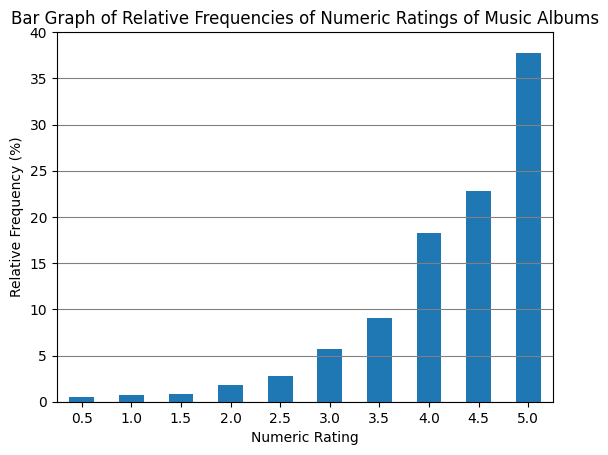

In [12]:
ratings_rf_values = reviews_df['Rating'].value_counts(normalize = True).sort_index() * 100

ratings_bar_plot = ratings_rf_values.plot(kind = 'bar')

ratings_bar_plot.set_title('Bar Graph of Relative Frequencies of Numeric Ratings of Music Albums')
ratings_bar_plot.set_xlabel('Numeric Rating')
ratings_bar_plot.set_ylabel('Relative Frequency (%)')

plt.grid(axis = 'y', color = 'gray')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 45, step = 5))

plt.show()

Over 35% of the ratings are a perfect 5.0, a larger percentage than the percentage of reviews that are less than or equal to 2.5. This is clearly a highly unbalanced dataset.

Let's create a new column, **Positive**, where "1" means the corresponding **Rating** value is greater than 2.5, and "0" means it is less than or equal to 2.5.

In [13]:
reviews_df['Positive'] = (reviews_df['Rating'] > 2.5).astype(int)

In [14]:
reviews_df['Positive'].value_counts()

Positive
1    72789
0     5159
Name: count, dtype: int64

In the next line, I use another approach to calculate the number of positive and negative reviews to verify the above column was correctly engineered.

In [15]:
print('There are', len(reviews_df[reviews_df['Rating'] > 2.5]), 'positive reviews and', len(reviews_df[reviews_df['Rating'] <= 2.5]), 'negative reviews in the dataset.')

There are 72789 positive reviews and 5159 negative reviews in the dataset.


Great! The **Positive** column has been engineered correctly.

I think it is appropriate to visualize the class imbalance using the new column.

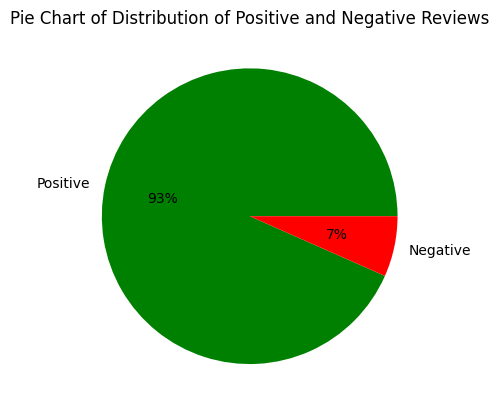

In [16]:
pos_neg_labels = ['Positive', 'Negative']

pos_neg_percents = [len(reviews_df[reviews_df['Positive'] == 1]), len(reviews_df[reviews_df['Positive'] == 0])]

plt.pie(pos_neg_percents, autopct = lambda p:'{:.0f}%'.format(round(p)), colors = ['green', 'red'], labels = pos_neg_labels)

plt.title('Pie Chart of Distribution of Positive and Negative Reviews')

plt.show()

I suspect that not all of the non-null **Review** values are worth keeping. In particular, I worry that some of the reviews are extremely short, to the point that they have no substance and/or are incomprehensible. Let's now engineer a column that stores the character count of each review as well as a column that stores the word count of each review.

In [17]:
reviews_df['Character_Count'] = reviews_df['Review'].apply(len)

In [18]:
reviews_df['Word_Count'] = reviews_df['Review'].apply(lambda x: len(x.split()))

In [19]:
reviews_df.head(10)

,Review,Rating,Positive,Character_Count,Word_Count
0,i think i actually under-rate ok computer if a...,5.0,1,2644,505
1,i get why radiohead rub a lot of people the wr...,5.0,1,5418,998
2,i would like to think i am good about not lett...,4.5,1,8391,1478
3,there are radiohead devotees like there were o...,4.0,1,2574,438
4,i wrote a shining excellent review for this al...,5.0,1,4433,813
5,hurrah finally i had my first radiohead experi...,2.5,0,979,177
6,radiohead i nigel godrich wytworzyli prawdziwi...,5.0,1,227,27
7,so let me get this straight. a bunch of one-hi...,2.5,0,961,155
8,i can sort of understand the praise this album...,2.0,0,801,149
9,i can see a few progressive rock elements in t...,2.0,0,1822,318


In [20]:
reviews_df['Character_Count'].describe()

count    77948.000000
mean       909.492097
std       1450.857260
min          1.000000
25%        174.000000
50%        430.000000
75%       1039.000000
max      32117.000000
Name: Character_Count, dtype: float64

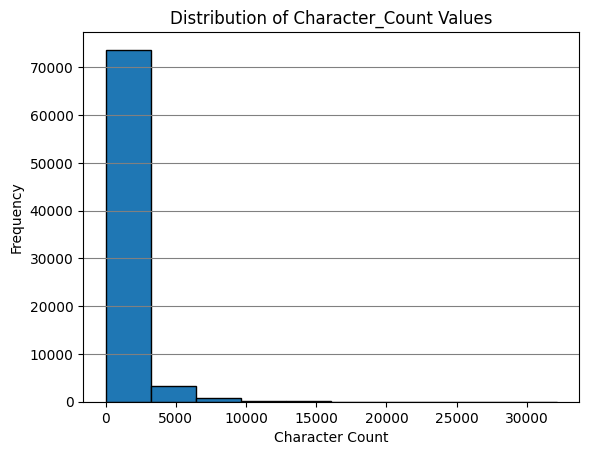

In [21]:
reviews_df['Character_Count'].plot(kind = 'hist', edgecolor = 'black', title = 'Distribution of Character_Count Values')

plt.grid(axis = 'y', color = 'gray')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.show()

Clearly, the overwhelming majority of the reviews have a **Character_Count** of at most 5000. 

I would like to plot this histogram again, but without the high outliers.

In [22]:
character_count_iqr = reviews_df['Character_Count'].quantile(q = 0.75) - reviews_df['Character_Count'].quantile(q = 0.25)

character_count_high_outlier_value = reviews_df['Character_Count'].quantile(q = 0.75) + 1.5 * character_count_iqr

print('A Character_Count value is a high outlier if it is greater than', character_count_high_outlier_value)

A Character_Count value is a high outlier if it is greater than 2336.5


For the next plot, I decided to round the high outlier value to the nearest multiple of 200 to make the bins and x-ticks align nicely. 

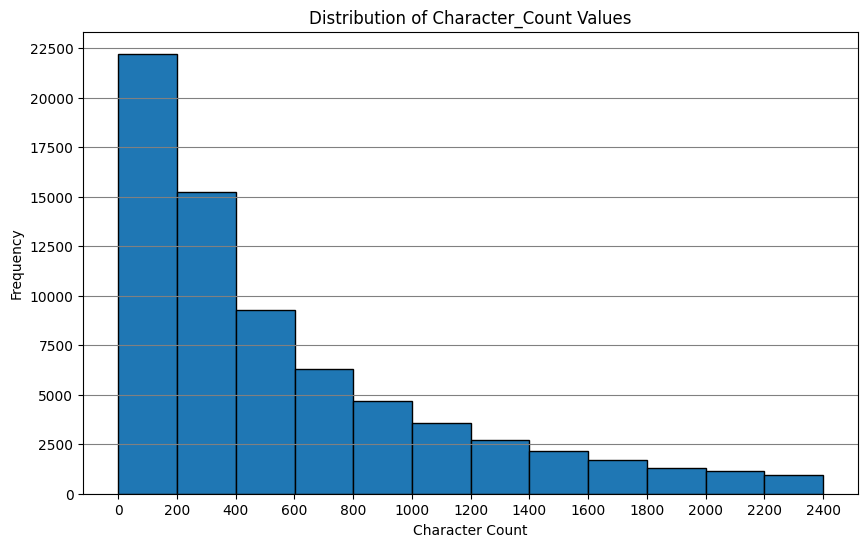

In [23]:
reviews_df[reviews_df['Character_Count'] <= 2400]['Character_Count'].plot(figsize = (10, 6), kind = 'hist', 
                            bins = 12, edgecolor = 'black', title = 'Distribution of Character_Count Values')

plt.grid(axis = 'y', color = 'gray')
plt.xlabel('Character Count')
plt.xticks(np.arange(0, 2600, step = 200))
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 25000, step = 2500))

plt.show()

In [24]:
reviews_df['Word_Count'].describe()

count    77948.000000
mean       165.096629
std        262.099916
min          0.000000
25%         32.000000
50%         79.000000
75%        189.000000
max       5970.000000
Name: Word_Count, dtype: float64

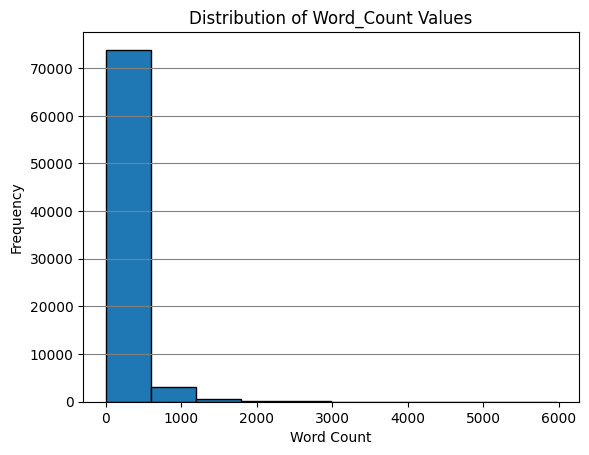

In [25]:
reviews_df['Word_Count'].plot(kind = 'hist', edgecolor = 'black', title = 'Distribution of Word_Count Values')

plt.grid(axis = 'y', color = 'gray')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.show()

Similarly, I think it makes sense to plot the histogram of the distribution of word counts without the high outliers.

In [26]:
word_count_iqr = reviews_df['Word_Count'].quantile(q = 0.75) - reviews_df['Word_Count'].quantile(q = 0.25)

word_count_high_outlier_value = reviews_df['Word_Count'].quantile(q = 0.75) + 1.5 * word_count_iqr

print('A Word_Count value is a high outlier if it is greater than', word_count_high_outlier_value)

A Word_Count value is a high outlier if it is greater than 424.5


The above high outlier value gets rounded up to the nearest multiple of 50 to make the bins and x-ticks align nicely. 

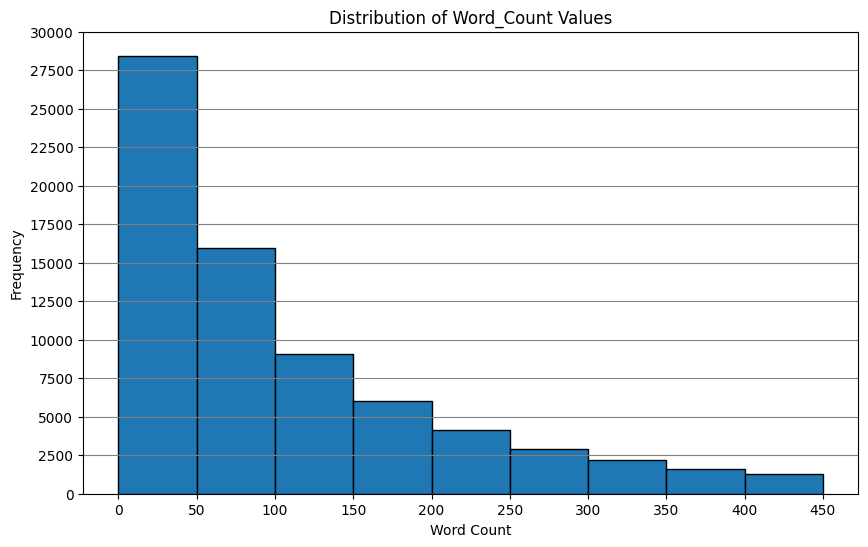

In [27]:
reviews_df[reviews_df['Word_Count'] <= 450]['Word_Count'].plot(figsize = (10, 6), kind = 'hist', 
                    bins = 9, edgecolor = 'black', title = 'Distribution of Word_Count Values')

plt.grid(axis = 'y', color = 'gray')
plt.xlabel('Word Count')
plt.xticks(np.arange(0, 500, step = 50))
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 32500, step = 2500))

plt.show()

There is at least one row with a **Character_Count** of 1 and at least one row with a **Word_Count** of 0. Perhaps it goes without saying, but these rows have no substance, and therefore are of no use. Let's investigate what is going on in these rows.

In [28]:
reviews_df[(reviews_df['Character_Count'] <= 18) | (reviews_df['Word_Count'] <= 3)].sample(20, random_state = 123)

,Review,Rating,Positive,Character_Count,Word_Count
28608,. .,3.5,1,34,2
37564,obra magna.,5.0,1,11,2
11284,magnificent.,5.0,1,12,1
11393,,4.5,1,4,0
35135,.,4.5,1,10,1
53688,absolutely essential.,4.5,1,21,2
62125,another perfect record.,5.0,1,23,3
53734,a classic!,5.0,1,10,2
14566,. ?,2.5,0,11,2
47422,- . .,2.0,0,30,3


Apparently, there are many rows where the **Review** is merely a string of meaningless characters, e.g. punctuation and/or spaces.

I wonder to what extent cleaning the text will help separate the meaningful reviews from the meaningless. 

The function in the next line will convert all text to lowercase (if it isn't already) and delete all numbers, punctuations marks, non-alphabetic characters, and excessive spaces.

In [29]:
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-z\']', ' ', text)
    cleaned_text = " ".join(cleaned_text.split())
    cleaned_text = cleaned_text.lower()
    return cleaned_text

In [30]:
reviews_df.insert(loc = 1, column = 'Review_Cleaned', value = reviews_df['Review'].apply(clean_text))

How did cleaning the text affect the character and word counts?

In [31]:
reviews_df = reviews_df.rename(columns = {'Character_Count':'Characters_Original', 'Word_Count':'Words_Original'})

In [32]:
reviews_df['Characters_Cleaned'] = reviews_df['Review_Cleaned'].apply(len)

In [33]:
reviews_df['Words_Cleaned'] = reviews_df['Review_Cleaned'].apply(lambda x: len(x.split()))

In [34]:
reviews_df[(reviews_df['Characters_Original'] <= 18) | (reviews_df['Words_Original'] <= 3)].sample(20, random_state = 123)

,Review,Review_Cleaned,Rating,Positive,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned
28608,. .,,3.5,1,34,2,0,0
37564,obra magna.,obra magna,5.0,1,11,2,10,2
11284,magnificent.,magnificent,5.0,1,12,1,11,1
11393,,,4.5,1,4,0,0,0
35135,.,,4.5,1,10,1,0,0
53688,absolutely essential.,absolutely essential,4.5,1,21,2,20,2
62125,another perfect record.,another perfect record,5.0,1,23,3,22,3
53734,a classic!,a classic,5.0,1,10,2,9,2
14566,. ?,,2.5,0,11,2,0,0
47422,- . .,,2.0,0,30,3,0,0


Fantastic! The rows whose reviews were originally meaningless punctuation now have character and word counts of 0, as they should.

These rows get dropped from the dataframe in the next line.

In [35]:
reviews_df = reviews_df[reviews_df['Words_Cleaned'] != 0]

reviews_df = reviews_df.reset_index(drop = True)

In [36]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77628 entries, 0 to 77627
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Review               77628 non-null  object 
 1   Review_Cleaned       77628 non-null  object 
 2   Rating               77628 non-null  float64
 3   Positive             77628 non-null  int32  
 4   Characters_Original  77628 non-null  int64  
 5   Words_Original       77628 non-null  int64  
 6   Characters_Cleaned   77628 non-null  int64  
 7   Words_Cleaned        77628 non-null  int64  
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 4.4+ MB


The dataframe now has 77948 – 77628 = 320 fewer rows, which is not a huge loss.

In [37]:
reviews_df['Characters_Cleaned'].describe()

count    77628.000000
mean       897.387309
std       1433.137012
min          1.000000
25%        170.000000
50%        423.000000
75%       1026.000000
max      31730.000000
Name: Characters_Cleaned, dtype: float64

In [38]:
reviews_df['Words_Cleaned'].describe()

count    77628.000000
mean       165.616079
std        262.637956
min          1.000000
25%         32.000000
50%         79.000000
75%        190.000000
max       5955.000000
Name: Words_Cleaned, dtype: float64

There still are reviews that are unusually short, e.g. 1 character. Let's have a look at some of the reviews of this sort.

In [39]:
reviews_df[reviews_df['Characters_Cleaned'] == 1]

,Review,Review_Cleaned,Rating,Positive,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned
38522,. a . .,a,3.5,1,32,4,1,1
45686,- n1- . - ! ...,n,3.5,1,111,10,1,1
53392,- - - d,d,4.0,1,11,4,1,1
55169,d,d,3.5,1,6,1,1,1


These four reviews are meaningless, and therefore should be dropped.

In [40]:
reviews_df = reviews_df[reviews_df['Characters_Cleaned'] != 1]

reviews_df = reviews_df.reset_index(drop = True)

I suspect that the reviews with only 2 characters are also worthless.

In [41]:
reviews_df[reviews_df['Characters_Cleaned'] == 2]

,Review,Review_Cleaned,Rating,Positive,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned
3855,hi,hi,5.0,1,2,1,2,1
5612,eh,eh,2.0,0,2,1,2,1
17332,la . .,la,5.0,1,41,3,2,1
20886,jd. . . .,jd,5.0,1,45,4,2,1
23522,ye . . .,ye,3.5,1,40,4,2,1


Indeed, these five reviews should be dropped.

In [42]:
reviews_df = reviews_df[reviews_df['Characters_Cleaned'] != 2]

reviews_df = reviews_df.reset_index(drop = True)

Reviews that are 3 characters long might be meaningful. For example, a review that consists of merely the word "bad" is a meaningful way to express disliking a music album.

In [43]:
reviews_df[reviews_df['Characters_Cleaned'] == 3]

,Review,Review_Cleaned,Rating,Positive,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned
2005,wow...,wow,5.0,1,6,1,3,1
2125,wow,wow,5.0,1,3,1,3,1
3781,- 3.0. upd . .,upd,2.5,0,28,5,3,1
4580,meh,meh,2.5,0,3,1,3,1
5259,- rym . ...,rym,3.5,1,53,5,3,1
11316,nas,nas,4.0,1,3,1,3,1
11367,cap,cap,3.0,1,3,1,3,1
17287,low .,low,4.5,1,18,2,3,1
21000,sad.,sad,5.0,1,4,1,3,1
26883,. a b . 11 .,a b,3.0,1,34,6,3,2


As expected, some 3-character reviews are helpful, e.g. "wow" and "meh". That said, many of them are meaningless, e.g. "a b" and "nas".

I will need to apply a more robust method to determine which short reviews are meaningful and which aren't. I will revisit this later.

Let's see how the character and word count distributions look like for the cleaned reviews.

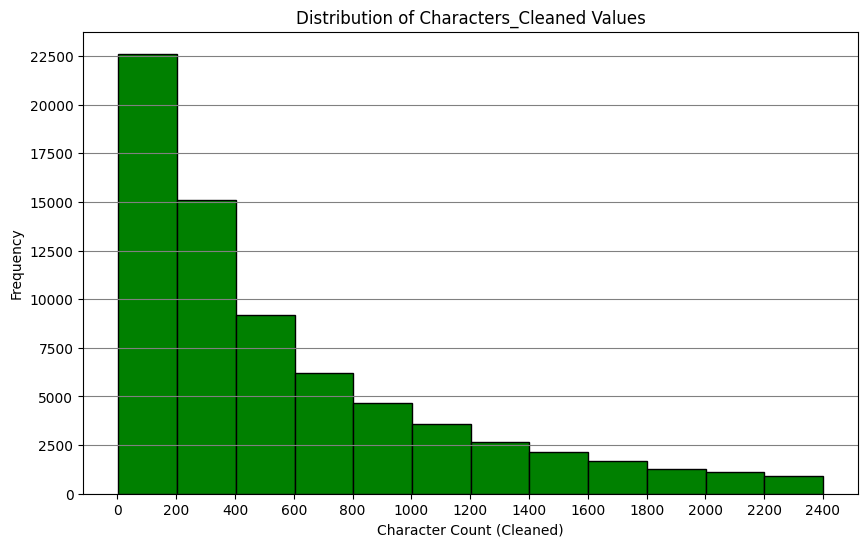

In [44]:
reviews_df[reviews_df['Characters_Cleaned'] <= 2400]['Characters_Cleaned'].plot(figsize = (10, 6), kind = 'hist', 
                      bins = 12, color = 'green', edgecolor = 'black', title = 'Distribution of Characters_Cleaned Values')

plt.grid(axis = 'y', color = 'gray')
plt.xlabel('Character Count (Cleaned)')
plt.xticks(np.arange(0, 2600, step = 200))
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 25000, step = 2500))

plt.show()

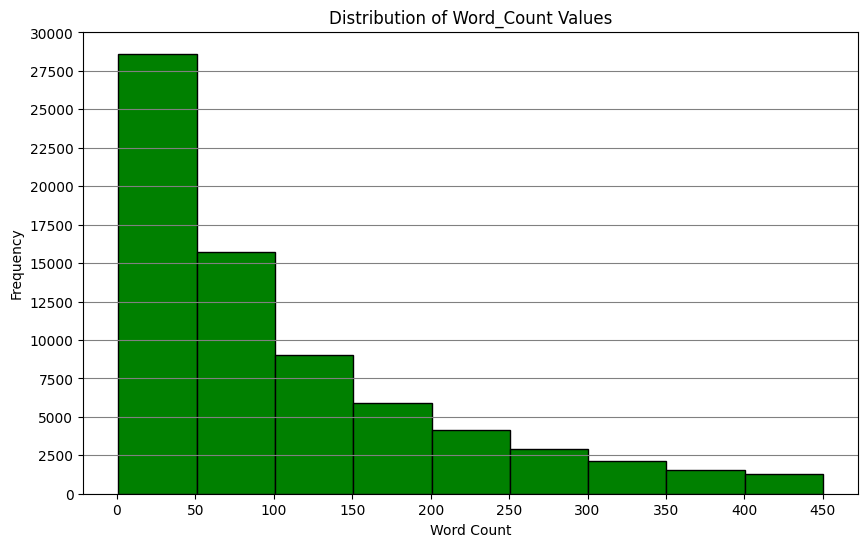

In [45]:
reviews_df[reviews_df['Words_Cleaned'] <= 450]['Words_Cleaned'].plot(figsize = (10, 6), kind = 'hist', 
           bins = 9, color = 'green', edgecolor = 'black', title = 'Distribution of Word_Count Values')

plt.grid(axis = 'y', color = 'gray')
plt.xlabel('Word Count')
plt.xticks(np.arange(0, 500, step = 50))
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 32500, step = 2500))

plt.show()

There are no drastic differences in the distributions.

## Handling the non-English Reviews <a id = 4></a>

I noticed earlier that the seventh review is not written in English (rather, it is written in Polish). How many of the reviews are written in a foreign language?

**<u>NOTE</u>:** The **in_english** function can take several minutes to apply, so I deliberately commented out applying it after saving the results in a new dataframe.

In [46]:
DetectorFactory.seed = 0

def in_english(text):

    try:
        return detect(text) == 'en'

    except:
        return False

In [47]:
# reviews_df.insert(loc = 4, column = 'In_English', value = reviews_df['Review_Cleaned'].apply(in_english))

In [48]:
# reviews_df.to_csv('Main Dataframe/music_album_reviews_v2.csv', index = False)

In [49]:
reviews_df = pd.read_csv('Main Dataframe/music_album_reviews_v2.csv')

In [50]:
reviews_df.head(10)

,Review,Review_Cleaned,Rating,Positive,In_English,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned
0,i think i actually under-rate ok computer if a...,i think i actually under rate ok computer if a...,5.0,1,True,2644,505,2606,507
1,i get why radiohead rub a lot of people the wr...,i get why radiohead rub a lot of people the wr...,5.0,1,True,5418,998,5348,1005
2,i would like to think i am good about not lett...,i would like to think i am good about not lett...,4.5,1,True,8391,1478,8338,1492
3,there are radiohead devotees like there were o...,there are radiohead devotees like there were o...,4.0,1,True,2574,438,2525,444
4,i wrote a shining excellent review for this al...,i wrote a shining excellent review for this al...,5.0,1,True,4433,813,4346,811
5,hurrah finally i had my first radiohead experi...,hurrah finally i had my first radiohead experi...,2.5,0,True,979,177,959,179
6,radiohead i nigel godrich wytworzyli prawdziwi...,radiohead i nigel godrich wytworzyli prawdziwi...,5.0,1,False,227,27,226,27
7,so let me get this straight. a bunch of one-hi...,so let me get this straight a bunch of one hit...,2.5,0,True,961,155,941,159
8,i can sort of understand the praise this album...,i can sort of understand the praise this album...,2.0,0,True,801,149,792,148
9,i can see a few progressive rock elements in t...,i can see a few progressive rock elements in t...,2.0,0,True,1822,318,1787,314


In [51]:
reviews_df['In_English'].value_counts()

In_English
True     70392
False     7227
Name: count, dtype: int64

About 10.3% of the reviews are not written in English. This is a significant percentage, to the point that I do not think it is a good idea to drop them.

Instead, let's translate the cleaned versions of the reviews. Translating 7227 reviews one by one would be highly time-consuming, so I will translate them in batches. First, it would be good to know the distribution of languages in this set.

In [52]:
foreign_reviews_df = reviews_df[reviews_df['In_English'] == False].copy()

In [53]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except Exception as e:
        return None

In [54]:
# foreign_reviews_df.insert(loc = 4, column = 'Language', value = foreign_reviews_df['Review_Cleaned'].apply(detect_language))

In [55]:
# foreign_reviews_df.to_csv('Foreign Language Reviews/foreign_music_album_reviews.csv', index = False)

In [56]:
foreign_reviews_df = pd.read_csv('Foreign Language Reviews/foreign_music_album_reviews.csv')

In [57]:
foreign_reviews_df['Language'].value_counts()

Language
es    2533
fr    1078
it    1053
pt     707
pl     534
de     258
nl     128
da     127
en     107
ro      83
af      73
no      62
ca      58
hu      54
cy      44
sv      41
fi      39
tl      36
tr      35
so      30
et      28
hr      22
sl      20
lt      17
id      14
cs      11
sk      10
sw       9
sq       9
vi       5
lv       2
Name: count, dtype: int64

107 of the reviews are apparently written in English. The imprecision of the **detect** function should be documented to stakeholders.

That aside, it is worth mentioning how Spanish is <u>BY FAR</u> the most common foreign language used in these reviews. In fact, more reviews are written in Spanish than the number of reviews in the second most prevalent language (French) and third most prevalent language (Italian) combined.

I will first translate the non-English reviews where there are over 100 reviews of the same language, beginning with Danish (da) and then going in increasing order until the Spanish (es) reviews are translated.

In [58]:
translator = Translator()

### Handling the Danish Reviews <a id = 4.1></a>

In [59]:
# danish_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'da']

In [60]:
def danish_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'da', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [61]:
#danish_batch_size = 30

#danish_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(danish_reviews_df), danish_batch_size):
    
#    end = min(start + danish_batch_size, len(danish_reviews_df))
    
#    batch = danish_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = danish_translate(batch)

#    danish_reviews_df.iloc[start:end, danish_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [62]:
# danish_reviews_df.to_csv('Foreign Language Reviews/danish_music_album_reviews.csv', index = False)

In [63]:
danish_reviews_df = pd.read_csv('Foreign Language Reviews/danish_music_album_reviews.csv')

### Handling the Dutch Reviews <a id = 4.2></a>

In [64]:
# dutch_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'nl']

In [65]:
def dutch_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'nl', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [66]:
#dutch_batch_size = 30

#dutch_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(dutch_reviews_df), dutch_batch_size):
    
#    end = min(start + dutch_batch_size, len(dutch_reviews_df))
    
#    batch = dutch_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = dutch_translate(batch)

#    dutch_reviews_df.iloc[start:end, dutch_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [67]:
# dutch_reviews_df.to_csv('Foreign Language Reviews/dutch_music_album_reviews.csv', index = False)

In [68]:
dutch_reviews_df = pd.read_csv('Foreign Language Reviews/dutch_music_album_reviews.csv')

### Handling the German Reviews <a id = 4.3></a>

In [69]:
# german_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'de']

In [70]:
def german_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'de', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [71]:
#german_batch_size = 50

#german_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(german_reviews_df), german_batch_size):
    
#    end = min(start + german_batch_size, len(german_reviews_df))
    
#    batch = german_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = german_translate(batch)

#    german_reviews_df.iloc[start:end, german_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [72]:
# german_reviews_df.to_csv('Foreign Language Reviews/german_music_album_reviews.csv', index = False)

In [73]:
german_reviews_df = pd.read_csv('Foreign Language Reviews/german_music_album_reviews.csv')

### Handling the Polish Reviews <a id = 4.4></a>

In [74]:
# polish_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'pl']

In [75]:
def polish_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'pl', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [76]:
#polish_batch_size = 100

#polish_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(polish_reviews_df), polish_batch_size):
    
#    end = min(start + polish_batch_size, len(polish_reviews_df))
    
#    batch = polish_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = polish_translate(batch)

#    polish_reviews_df.iloc[start:end, polish_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [77]:
# polish_reviews_df.to_csv('Foreign Language Reviews/polish_music_album_reviews.csv', index = False)

In [78]:
polish_reviews_df = pd.read_csv('Foreign Language Reviews/polish_music_album_reviews.csv')

### Handling the Portuguese Reviews <a id = 4.5></a>

In [79]:
# portuguese_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'pt']

In [80]:
def portuguese_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'pt', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [81]:
#portuguese_batch_size = 140

#portuguese_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(portuguese_reviews_df), portuguese_batch_size):
    
#    end = min(start + portuguese_batch_size, len(portuguese_reviews_df))
    
#    batch = portuguese_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = portuguese_translate(batch)

#    portuguese_reviews_df.iloc[start:end, portuguese_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [82]:
# portuguese_reviews_df.to_csv('Foreign Language Reviews/portuguese_music_album_reviews.csv', index = False)

In [83]:
portuguese_reviews_df = pd.read_csv('Foreign Language Reviews/portuguese_music_album_reviews.csv')

### Handling the Italian Reviews <a id = 4.6></a>

In [84]:
# italian_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'it']

In [85]:
def italian_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'it', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [86]:
#italian_batch_size = 200

#italian_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(italian_reviews_df), italian_batch_size):
    
#    end = min(start + italian_batch_size, len(italian_reviews_df))
    
#    batch = italian_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = italian_translate(batch)

#    italian_reviews_df.iloc[start:end, italian_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [87]:
# italian_reviews_df.to_csv('Foreign Language Reviews/italian_music_album_reviews.csv', index = False)

In [88]:
italian_reviews_df = pd.read_csv('Foreign Language Reviews/italian_music_album_reviews.csv')

### Handling the French Reviews <a id = 4.7></a>

In [89]:
# french_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'fr']

In [90]:
def french_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'fr', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [91]:
#french_batch_size = 200

#french_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(french_reviews_df), french_batch_size):
    
#    end = min(start + french_batch_size, len(french_reviews_df))
    
#    batch = french_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = french_translate(batch)

#    french_reviews_df.iloc[start:end, french_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [92]:
# french_reviews_df.to_csv('Foreign Language Reviews/french_music_album_reviews.csv', index = False)

In [93]:
french_reviews_df = pd.read_csv('Foreign Language Reviews/french_music_album_reviews.csv')

### Handling the Spanish Reviews <a id = 4.8></a>

In [94]:
# spanish_reviews_df = foreign_reviews_df[foreign_reviews_df['Language'] == 'es']

In [95]:
def spanish_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'es', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [96]:
#spanish_batch_size = 500

#spanish_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(spanish_reviews_df), spanish_batch_size):
    
#    end = min(start + spanish_batch_size, len(spanish_reviews_df))
    
#    batch = spanish_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = spanish_translate(batch)

#    spanish_reviews_df.iloc[start:end, spanish_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [97]:
# spanish_reviews_df.to_csv('Foreign Language Reviews/spanish_music_album_reviews.csv', index = False)

In [98]:
spanish_reviews_df = pd.read_csv('Foreign Language Reviews/spanish_music_album_reviews.csv')

### Handling All Other Foreign Reviews <a id = 4.9></a>

How many rows have a review that is not written in English, Danish, Dutch, Polish, Portuguese, Italian, French, or Spanish? If this number is relatively small, then I could write a function that auto-detects which language the review is written in before translating it.

In [99]:
common_languages = ['en', 'nl', 'de', 'pl', 'pt', 'it', 'fr', 'es']

In [100]:
len(foreign_reviews_df[~foreign_reviews_df['Language'].isin(common_languages)])

829

I wouldn't think it would take an unreasonably long time to translate these 829 reviews, so let's group them together.

In [101]:
# other_languages_reviews_df = foreign_reviews_df[~foreign_reviews_df['Language'].isin(common_languages)]

In [102]:
def other_languages_translate(reviews):
    translations = []
    
    for review in tqdm(reviews, desc = "Translating"):
    
        try:
            translated = translator.translate(review, src = 'auto', dest = 'en')
            translations.append(translated.text)
    
        except Exception as e:
            translations.append(np.nan)
            print(f"Error translating: {e}")
    
    return translations

In [103]:
#other_languages_batch_size = 160

#other_languages_reviews_df['Translated_Review'] = np.nan

#for start in range(0, len(other_languages_reviews_df), other_languages_batch_size):
    
#    end = min(start + other_languages_batch_size, len(other_languages_reviews_df))
    
#    batch = other_languages_reviews_df['Review_Cleaned'].iloc[start:end]

#    translated_reviews = other_languages_translate(batch)

#    other_languages_reviews_df.iloc[start:end, other_languages_reviews_df.columns.get_loc('Translated_Review')] = translated_reviews

In [104]:
# other_languages_reviews_df.to_csv('Foreign Language Reviews/other_languages_music_album_reviews.csv', index = False)

In [105]:
other_languages_reviews_df = pd.read_csv('Foreign Language Reviews/other_languages_music_album_reviews.csv')

### Merging Translated Reviews to Main Dataframe <a id = 4.10></a>

In [106]:
reviews_df = pd.merge(reviews_df, other_languages_reviews_df[['Review_Cleaned', 'Translated_Review', 'Language']], how = 'outer', on = 'Review_Cleaned')

In [107]:
for dataframe in [danish_reviews_df, dutch_reviews_df, german_reviews_df, polish_reviews_df, portuguese_reviews_df, italian_reviews_df, french_reviews_df, spanish_reviews_df]:
    
    reviews_df = pd.merge(reviews_df, dataframe[['Review_Cleaned', 'Translated_Review', 'Language']], how = 'left', on = 'Review_Cleaned', suffixes = ('', '_new'))

    reviews_df['Translated_Review'] = reviews_df['Translated_Review'].combine_first(reviews_df['Translated_Review_new'])

    reviews_df['Language'] = reviews_df['Language'].combine_first(reviews_df['Language_new'])

    reviews_df.drop(columns = ['Translated_Review_new', 'Language_new'], inplace = True)

In [108]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78085 entries, 0 to 78084
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Review               78085 non-null  object 
 1   Review_Cleaned       78085 non-null  object 
 2   Rating               78085 non-null  float64
 3   Positive             78085 non-null  int64  
 4   In_English           78085 non-null  bool   
 5   Characters_Original  78085 non-null  int64  
 6   Words_Original       78085 non-null  int64  
 7   Characters_Cleaned   78085 non-null  int64  
 8   Words_Cleaned        78085 non-null  int64  
 9   Translated_Review    6543 non-null   object 
 10  Language             7586 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 6.0+ MB


The main dataframe now has more rows than it did before the merge. Could this be because the merging (somehow) created rows that are exact duplicates?

In [109]:
print('The dataframe has', len(reviews_df[reviews_df.duplicated(keep = False)].drop_duplicates()), 'rows that have at least one exact duplicate.')

The dataframe has 113 rows that have at least one exact duplicate.


It appears that my hunch is correct. The rows that are exact duplicates get dropped in the next line.

In [110]:
reviews_df = reviews_df.drop_duplicates().reset_index(drop = True)

In [111]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77649 entries, 0 to 77648
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Review               77649 non-null  object 
 1   Review_Cleaned       77649 non-null  object 
 2   Rating               77649 non-null  float64
 3   Positive             77649 non-null  int64  
 4   In_English           77649 non-null  bool   
 5   Characters_Original  77649 non-null  int64  
 6   Words_Original       77649 non-null  int64  
 7   Characters_Cleaned   77649 non-null  int64  
 8   Words_Cleaned        77649 non-null  int64  
 9   Translated_Review    6114 non-null   object 
 10  Language             7150 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 6.0+ MB


Regarding the reviews that were already written in English, the cleaned versions of them get copied over to the **Translated_Review** column in the next line.

In [112]:
reviews_df.loc[reviews_df['In_English'] == True, 'Translated_Review'] = reviews_df['Review_Cleaned']

The reviews that were already written in English should have a **Language** value of **en**.

In [113]:
reviews_df.loc[reviews_df['In_English'] == True, 'Language'] = 'en'

In [114]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77649 entries, 0 to 77648
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Review               77649 non-null  object 
 1   Review_Cleaned       77649 non-null  object 
 2   Rating               77649 non-null  float64
 3   Positive             77649 non-null  int64  
 4   In_English           77649 non-null  bool   
 5   Characters_Original  77649 non-null  int64  
 6   Words_Original       77649 non-null  int64  
 7   Characters_Cleaned   77649 non-null  int64  
 8   Words_Cleaned        77649 non-null  int64  
 9   Translated_Review    76506 non-null  object 
 10  Language             77542 non-null  object 
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 6.0+ MB


What is the situation with the rows with null **Language** values?

In [115]:
reviews_df[reviews_df['Language'].isna()].sample(20, random_state = 12345)

,Review,Review_Cleaned,Rating,Positive,In_English,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned,Translated_Review,Language
41311,najlepsza pyta death to kwestia wybitnie indyw...,najlepsza pyta death to kwestia wybitnie indyw...,5.0,1,False,5064,829,4978,826,NaN,NaN
35273,just a great album much better than dark side.,just a great album much better than dark side,5.0,1,False,46,9,45,9,NaN,NaN
2779,a well made neo-soul album.,a well made neo soul album,4.0,1,False,27,5,26,6,NaN,NaN
41385,naughty. sneaky.,naughty sneaky,5.0,1,False,16,2,14,2,NaN,NaN
19530,grouse album.,grouse album,5.0,1,False,13,2,12,2,NaN,NaN
40540,my favorite led zeppelin album.,my favorite led zeppelin album,5.0,1,False,31,5,30,5,NaN,NaN
11906,damn it takes a lonnnnnnnnnnnnng ass time to g...,damn it takes a lonnnnnnnnnnnnng ass time to g...,4.0,1,False,105,22,104,22,NaN,NaN
39710,more listening this record the more i convince...,more listening this record the more i convince...,3.0,1,False,760,127,746,127,NaN,NaN
36306,landmark album for a landmark sound.,landmark album for a landmark sound,4.5,1,False,36,6,35,6,NaN,NaN
9798,brilliant even if you are not british like me.,brilliant even if you are not british like me,4.5,1,False,46,9,45,9,NaN,NaN


Strange... most of these reviews are clearly written in English, but for some reason they were not detected as such by the **In_English** column. Perhaps because they are, for one reason or another, poorly written? Whatever the case, there are only 77649 – 77542 = 107 of them, so I can drop them without harming the quality of the machine learning models.

In [116]:
reviews_df = reviews_df[~reviews_df['Language'].isna()].reset_index(drop = True)

In [117]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77542 entries, 0 to 77541
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Review               77542 non-null  object 
 1   Review_Cleaned       77542 non-null  object 
 2   Rating               77542 non-null  float64
 3   Positive             77542 non-null  int64  
 4   In_English           77542 non-null  bool   
 5   Characters_Original  77542 non-null  int64  
 6   Words_Original       77542 non-null  int64  
 7   Characters_Cleaned   77542 non-null  int64  
 8   Words_Cleaned        77542 non-null  int64  
 9   Translated_Review    76506 non-null  object 
 10  Language             77542 non-null  object 
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 6.0+ MB


After I applied the translation functions to the foreign language reviews, I noticed that for many of the languages, if not all of them, some of the reviews did not translate. This explains why the **Translated_Review** column has null values. Those 77542 – 76506 = 1036 rows get dropped in the next line.

In [118]:
reviews_df = reviews_df.dropna(subset = ['Translated_Review']).reset_index(drop = True)

I think the **Translated_Review** column should go third, after **Review** and **Review_Cleaned**. I also think the **Language** column should go after **In_English**.

In [119]:
reviews_df_columns = ['Review', 'Review_Cleaned', 'Translated_Review', 'Rating', 'Positive', 'In_English', 
                      'Language', 'Characters_Original', 'Words_Original', 'Characters_Cleaned', 'Words_Cleaned']

reviews_df = reviews_df[reviews_df_columns]

Come to think of it, the **Review** column should be renamed to **Review_Original** and the **Translated_Review** to **Review_Translated** for clarity and consistency.

In [120]:
reviews_df = reviews_df.rename(columns = {'Review':'Review_Original', 'Translated_Review':'Review_Translated'})

In [121]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76506 entries, 0 to 76505
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Review_Original      76506 non-null  object 
 1   Review_Cleaned       76506 non-null  object 
 2   Review_Translated    76506 non-null  object 
 3   Rating               76506 non-null  float64
 4   Positive             76506 non-null  int64  
 5   In_English           76506 non-null  bool   
 6   Language             76506 non-null  object 
 7   Characters_Original  76506 non-null  int64  
 8   Words_Original       76506 non-null  int64  
 9   Characters_Cleaned   76506 non-null  int64  
 10  Words_Cleaned        76506 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 5.9+ MB


At the beginning of this project, the main dataframe had 77948 rows after I dropped the null **Review** and **Rating** values. It now has 76506, so somewhere in the cleaning and feature engineering processes 1442 rows were lost. Thankfully, this is only a less than 2% decrease.

More likely than not, the reviews that were translated from a foreign language have different character and word counts compared to their original cleaned versions. It would be nice to have columns with new counts.

In [122]:
reviews_df['Characters_Translated'] = reviews_df['Review_Translated'].apply(len)

In [123]:
reviews_df['Words_Translated'] = reviews_df['Review_Translated'].apply(lambda x: len(x.split()))

I don't like how the **Language** column uses the ISO 639-1 codes of the languages. I think using the full words would make the column much easier to understand.

In [124]:
def get_language_name(code):
    
    try:
        return langcodes.Language.get(code).display_name()
    
    except:
        return code

In [125]:
reviews_df['Language'] = reviews_df['Language'].apply(get_language_name)

In [126]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76506 entries, 0 to 76505
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Review_Original        76506 non-null  object 
 1   Review_Cleaned         76506 non-null  object 
 2   Review_Translated      76506 non-null  object 
 3   Rating                 76506 non-null  float64
 4   Positive               76506 non-null  int64  
 5   In_English             76506 non-null  bool   
 6   Language               76506 non-null  object 
 7   Characters_Original    76506 non-null  int64  
 8   Words_Original         76506 non-null  int64  
 9   Characters_Cleaned     76506 non-null  int64  
 10  Words_Cleaned          76506 non-null  int64  
 11  Characters_Translated  76506 non-null  int64  
 12  Words_Translated       76506 non-null  int64  
dtypes: bool(1), float64(1), int64(7), object(4)
memory usage: 7.1+ MB


I noticed that some, if not all, of the reviews translated from a foreign language begin with a capital letter. For the sake on consistency, all reviews should be written in lowercase.

In [127]:
reviews_df['Review_Translated'] = reviews_df['Review_Translated'].str.lower()

## Identifying Meaningful Sentences <a id = 5></a>

I would like to use this opportunity to apply a robust method that determines which short reviews (e.g. those that are three characters long) are meaningful and which aren't.

The function below does the following: 

(1) Assesses the sentiment of each review. Short reviews that express moderate to strong sentiment, including one-word reviews such as "excellent", "fantastic", "terrible", and "horrible", get labeled as meaningful. 

(2) Checks for meaningful words, which are words that are not stop words (e.g. the, and, is, in, to). If a review does not have any meaningful words, then it is not a meaningful review. 

(3) Determines if a review has at least one noun and at least one adjective and/or adverb, in which case it is more likely than not meaningful.

(4) Identifies if a review has at least one subject and at least one verb, in which case it is more likely than not meaningful.

In [128]:
analyzer = SentimentIntensityAnalyzer()

nlp = spacy.load('en_core_web_sm')

stop_words = set(stopwords.words('english'))

In [129]:
def is_meaningful_sentence(review_text):

    sentiment_score = analyzer.polarity_scores(review_text)

    if sentiment_score['compound'] <= -0.25 or sentiment_score['compound'] >= 0.25:
        return True
    
    doc = nlp(review_text)
    meaningful_words = [token.text for token in doc if token.text not in stop_words]
    
    if len(meaningful_words) == 0:
        return False

    has_adjective = any(token.pos_ == 'ADJ' for token in doc)
    has_adverb = any(token.pos_ == 'ADV' for token in doc)
    has_noun = any(token.pos_ == 'NOUN' for token in doc)

    if has_noun and (has_adjective or has_adverb):
        return True

    has_subject = any(token.dep_ == 'nsubj' for token in doc)
    has_verb = any(token.pos_ == 'VERB' for token in doc)
    
    if has_subject and has_verb:
        return True
    
    return False

<u>**NOTE**</u>: Regarding the **compound** score...

– A score of -1 indicates a highly negative sentiment.

– A score of 1 indicates a highly positive sentiment.

– A score of 0 indicates a neutral sentiment.

Admittedly, the threshold of ±0.25 was chosen arbitrarily. The results might be significantly different depending on the threshold used, something that stakeholders should know.

It would take a long time to apply the function to every row in the dataframe, so I will apply it only to the rows with 15 or fewer words.

In [130]:
reviews_df['Is_Meaningful'] = True

In [131]:
short_reviews = reviews_df['Words_Translated'] <= 15

reviews_df.loc[short_reviews, 'Is_Meaningful'] = reviews_df.loc[short_reviews, 'Review_Translated'].apply(is_meaningful_sentence)

In [132]:
reviews_df['Is_Meaningful'].value_counts()

Is_Meaningful
True     75811
False      695
Name: count, dtype: int64

Let's look at a sample of reviews that, apparently, are not meaningful to see if the function appears to have worked correctly.

In [133]:
reviews_df[reviews_df['Is_Meaningful'] == False]['Review_Translated'].sample(20, random_state = 12345)

53459                                         space oddity
12851               discipline talking heads elephant talk
76100    you have been through awwwl of f scott fizgera...
40652                                                 name
47120                                  pj where is my mind
72391                    what a way to go godspeed j dilla
39710                          my drinking album of choice
15230                                        ex lion tamer
17781          geogaddi sidmdrum loopsboards of canadawarp
34546               jimi hendrix inventing electric guitar
54851                            tghis music is scaury bro
31741    instability in your ears instability in your life
58720                                 the peak of humanity
49467                                   red house painters
48208                             produced by pyramid head
48731                                         quite a trip
38576                                    metal to the bo

Judging by the above sample, the function appears to do at least a pretty good job of identifying reviews that are not meaningful. "name" and "produced by pyramid head" are obvious examples of reviews that show absolutely no sentiment towards the music album(s). The function also seems to identify reviews that have significant typos or are gibberish, e.g. "tghis music is scaury bro" and "geogaddi sidmdrum loopsboards of canadawarp".

As expected, the function is not perfect (for example, the review "my drinking album of choice" is clearly a positive review). Fortunately, even if some meaningful reviews are lost by me dropping these 695 reviews, the total loss of the 77948 rows there were after I dropped the null **Review** and **Rating** values is only about 2.74%.

In [134]:
reviews_df = reviews_df[reviews_df['Is_Meaningful'] == True]

reviews_df = reviews_df.reset_index(drop = True)

There is no need for the **Is_Meaningful** column anymore.

In [135]:
reviews_df = reviews_df.drop(columns = 'Is_Meaningful')

In [136]:
reviews_df.sample(20, random_state = 7777)

,Review_Original,Review_Cleaned,Review_Translated,Rating,Positive,In_English,Language,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned,Characters_Translated,Words_Translated
75534,you know what is annoying about many critics w...,you know what is annoying about many critics w...,you know what is annoying about many critics w...,4.0,1,True,English,1238,219,1226,220,1226,220
67538,this sad-but-giggly album by the flaming lips ...,this sad but giggly album by the flaming lips ...,this sad but giggly album by the flaming lips ...,3.5,1,True,English,414,73,410,75,410,75
51582,so i saw this documentary on these guys on sun...,so i saw this documentary on these guys on sun...,so i saw this documentary on these guys on sun...,2.0,0,True,English,559,102,554,102,554,102
34438,judas priest them seu modo mais destruidor com...,judas priest them seu modo mais destruidor com...,judas priest them his most destructive mode wi...,5.0,1,False,Portuguese,175,28,173,28,170,29
21479,i am not going to lie and say that i really un...,i am not going to lie and say that i really un...,i am not going to lie and say that i really un...,3.5,1,True,English,982,184,970,186,970,186
49389,revisiting this for nostalgias sake and it tur...,revisiting this for nostalgias sake and it tur...,revisiting this for nostalgias sake and it tur...,3.0,1,True,English,421,82,416,82,416,82
42007,note this review was originally posted on sept...,note this review was originally posted on sept...,note this review was originally posted on sept...,5.0,1,True,English,1158,214,1140,214,1140,214
41654,55. not much to say feeling too lethargic to e...,not much to say feeling too lethargic to expla...,not much to say feeling too lethargic to expla...,5.0,1,True,English,100,20,92,18,92,18
16700,3.5 for the bonus cd such that the album taken...,for the bonus cd such that the album taken as ...,for the bonus cd such that the album taken as ...,3.0,1,True,English,1041,202,1022,200,1022,200
30393,in a layered mixture of distorted strings voca...,in a layered mixture of distorted strings voca...,in a layered mixture of distorted strings voca...,5.0,1,True,English,674,111,670,111,670,111


I think the dataframe looks great! Let's save this updated version to a new CSV file.

In [137]:
# reviews_df.to_csv('Main Dataframe/music_album_reviews_v3.csv', index = False)

## Lemmatization <a id = 6></a>

I will now apply lemmatization, a technique that converts words to their root meanings, to the cleaned and translated reviews.

In [138]:
reviews_df = pd.read_csv('Main Dataframe/music_album_reviews_v3.csv')

In [139]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

def lemmatize_text(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text]
    lemmatized_text = " ".join(lemmas)
    return lemmatized_text

In [140]:
# reviews_df.insert(loc = 3, column = 'Review_Lemmatized', value = reviews_df['Review_Translated'].apply(lemmatize_text))

In [141]:
# reviews_df.to_csv('Main Dataframe/music_album_reviews_v4.csv', index = False)

Now that I have done more work on this dataframe, I should check to see if there are any rows that are exact duplicates.

In [142]:
reviews_df = pd.read_csv('Main Dataframe/music_album_reviews_v4.csv')

Strange... these reviews are clearly written in English, but for some reason they were labeled as being written in Danish.

In [143]:
reviews_df[reviews_df.duplicated(keep = False)]

,Review_Original,Review_Cleaned,Review_Translated,Review_Lemmatized,Rating,Positive,In_English,Language,Characters_Original,Words_Original,Characters_Cleaned,Words_Cleaned,Characters_Translated,Words_Translated
8387,best album ever made?,best album ever made,best album ever made,good album ever make,5.0,1,False,Danish,21,4,20,4,20,4
8388,best album ever made?,best album ever made,best album ever made,good album ever make,5.0,1,False,Danish,21,4,20,4,20,4
8389,best album ever made,best album ever made,best album ever made,good album ever make,5.0,1,False,Danish,20,4,20,4,20,4
8390,best album ever made,best album ever made,best album ever made,good album ever make,5.0,1,False,Danish,20,4,20,4,20,4


There is no need to keep all four of these reviews: one will suffice.

In [144]:
reviews_df = reviews_df.drop(index = [8441, 8442, 8443])

In [145]:
reviews_df.loc[(reviews_df.index == 8444) , 'In_English'] = True

reviews_df.loc[(reviews_df.index == 8444) , 'Language'] = 'English'

In [146]:
reviews_df = reviews_df.reset_index(drop = True)

In [147]:
# reviews_df.to_csv('Main Dataframe/music_album_reviews_v5.csv', index = False)

In [148]:
reviews_df = pd.read_csv('Main Dataframe/music_album_reviews_v5.csv')

In [149]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75808 entries, 0 to 75807
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Review_Original        75808 non-null  object 
 1   Review_Cleaned         75808 non-null  object 
 2   Review_Translated      75808 non-null  object 
 3   Review_Lemmatized      75808 non-null  object 
 4   Rating                 75808 non-null  float64
 5   Positive               75808 non-null  int64  
 6   In_English             75808 non-null  bool   
 7   Language               75808 non-null  object 
 8   Characters_Original    75808 non-null  int64  
 9   Words_Original         75808 non-null  int64  
 10  Characters_Cleaned     75808 non-null  int64  
 11  Words_Cleaned          75808 non-null  int64  
 12  Characters_Translated  75808 non-null  int64  
 13  Words_Translated       75808 non-null  int64  
dtypes: bool(1), float64(1), int64(7), object(5)
memory usa

As intended, the version of the main dataframe from after lemmatization has 3 fewer rows than the version from before.

## Train/Validation/Test Split & Vectorization <a id = 7></a>

Let's do the conventional 60/20/20 split between the training, validation, and test sets.

In [150]:
train_df, valid_and_test_df = train_test_split(reviews_df, test_size = 0.4, random_state = 12345, stratify = reviews_df['Positive'])

valid_df, test_df = train_test_split(valid_and_test_df, test_size = 0.5, random_state = 12345)

I stratified the **Positive** column when splitting the training set from the combined validation and test set. This is a great idea in the event of a significant class imbalance (as we have here) because it ensures the training set has a representative distribution of each class, thereby allowing the models to train more accurately.

I did not apply stratification when splitting the validation and test sets because class proportions are less critical for these sets. In fact, having different class distributions in these sets can be a good thing, as it allows for evaluating the model's ability to handle varying class proportions, which in turn shows its robustness.

In [151]:
train_df['Positive'].value_counts()

Positive
1    42473
0     3011
Name: count, dtype: int64

As mentioned earlier, there is a large class imbalance that needs to be addressed before the models are trained.

I am curious to see if adding more rows with an **Positive** value of 0 to the training set would improve the model. 

I will do this by upsampling, which is done by performing the following steps:

1) Splitting the training sample into positive and negative observations.

2) Duplicating the negative observations multiple times.

3) Creating a new training sample based on the data obtained.

4) Shuffling the data.

First, let's split the training, validation, and test sets into features and target dataframes.

In [152]:
train_features = train_df.drop(['Positive'], axis = 1).copy()
train_target = train_df['Positive'].copy()

valid_features = valid_df.drop(['Positive'], axis = 1).copy()
valid_target = valid_df['Positive'].copy()

test_features = test_df.drop(['Positive'], axis = 1).copy()
test_target = test_df['Positive'].copy()

In [153]:
print(train_features.shape)
print(train_target.shape)
print()
print(valid_features.shape)
print(valid_target.shape)
print()
print(test_features.shape)
print(test_target.shape)

(45484, 13)
(45484,)

(15162, 13)
(15162,)

(15162, 13)
(15162,)


Now let's define the upsample function.

In [154]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] * repeat + [features_ones])
    target_upsampled = pd.concat([target_zeros] * repeat + [target_ones])

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)

    return features_upsampled, target_upsampled

Since there are about 14 times more positive reviews than negative reviews, I will set the **repeat** value to 14.

In [155]:
train_features_upsampled, train_target_upsampled = upsample(train_features, train_target, 14)

In [156]:
train_target_upsampled.value_counts()

Positive
1    42473
0    42154
Name: count, dtype: int64

GREAT! The ratio of positive to negative reviews is now close to 1:1, meaning the class imbalance has been resolved!

In [157]:
stop_words = list(stopwords.words('english'))

vectorizer = TfidfVectorizer(stop_words = stop_words)

I will use the upsampled training sets to train the models, but I will use the training sets without upsampling to help assess the accuracy of the models (since the models are likely going to overfit the upsampled training sets).

In [158]:
train_text_corpus = train_features['Review_Lemmatized'].copy()
train_text_vectorized = vectorizer.fit_transform(train_text_corpus)

train_text_upsampled_corpus = train_features_upsampled['Review_Lemmatized'].copy()
train_text_upsampled_vectorized = vectorizer.fit_transform(train_text_upsampled_corpus)

valid_text_corpus = valid_features['Review_Lemmatized'].copy()
valid_text_vectorized = vectorizer.transform(valid_text_corpus)

test_text_corpus = test_features['Review_Lemmatized'].copy()
test_text_vectorized = vectorizer.transform(test_text_corpus)

## Training Different Models <a id = 8></a>

Recall that the minimum acceptable accuracy score is 90%.

### Logistic Regression <a id = 8.1></a>

In [159]:
%%time

logistic_regression = LogisticRegression()
logistic_regression.fit(train_text_upsampled_vectorized, train_target_upsampled)

CPU times: total: 703 ms
Wall time: 957 ms


LogisticRegression()

In [160]:
logistic_regression_predict_train = logistic_regression.predict(train_text_vectorized)
logistic_regression_predict_valid = logistic_regression.predict(valid_text_vectorized)

print('Training Set Accuracy Score:', round(accuracy_score(train_target, logistic_regression_predict_train) * 100, 1), '%')
print('Validation Set Accuracy Score:', round(accuracy_score(valid_target, logistic_regression_predict_valid) * 100, 1), '%')

Training Set Accuracy Score: 89.8 %
Validation Set Accuracy Score: 87.9 %


Close, but not quite accurate enough. Let's try a different model.

### CatBoostClassifier <a id = 8.2></a>

In [161]:
%%time

catboost_classifier = CatBoostClassifier(random_state = 12345, verbose = 100)
catboost_classifier.fit(train_text_upsampled_vectorized, train_target_upsampled)

Learning rate set to 0.068546
0:	learn: 0.6824313	total: 849ms	remaining: 14m 7s
100:	learn: 0.4926145	total: 1m 33s	remaining: 13m 51s
200:	learn: 0.4322903	total: 2m 48s	remaining: 11m 8s
300:	learn: 0.3840513	total: 4m 7s	remaining: 9m 33s
400:	learn: 0.3481415	total: 5m 22s	remaining: 8m 2s
500:	learn: 0.3183603	total: 7m 30s	remaining: 7m 28s
600:	learn: 0.2928556	total: 9m 6s	remaining: 6m 2s
700:	learn: 0.2716553	total: 10m 6s	remaining: 4m 18s
800:	learn: 0.2523762	total: 11m 37s	remaining: 2m 53s
900:	learn: 0.2357205	total: 12m 43s	remaining: 1m 23s
999:	learn: 0.2205942	total: 13m 51s	remaining: 0us
CPU times: total: 1h 15min 56s
Wall time: 13min 56s


In [162]:
catboost_classifier_predict_train = catboost_classifier.predict(train_text_vectorized)
catboost_classifier_predict_valid = catboost_classifier.predict(valid_text_vectorized)

print('Training Set Accuracy Score:', round(accuracy_score(train_target, catboost_classifier_predict_train) * 100, 1), '%')
print('Validation Set Accuracy Score:', round(accuracy_score(valid_target, catboost_classifier_predict_valid) * 100, 1), '%')

Training Set Accuracy Score: 93.0 %
Validation Set Accuracy Score: 89.3 %


Great! This model acquired an accuracy score of 89.3% on the validation set without any hyperparameter tuning!

I have little doubt that this model is capable of scoring at least 90% on the validation set after a little tuning. What are this model's hyperparameters anyways?

In [163]:
for param, value in sorted(catboost_classifier.get_all_params().items()):
    print(f"{param}: {value}")

auto_class_weights: None
bayesian_matrix_reg: 0.10000000149011612
best_model_min_trees: 1
boost_from_average: False
boosting_type: Plain
bootstrap_type: MVS
border_count: 254
class_names: [0, 1]
classes_count: 0
depth: 6
eval_fraction: 0
eval_metric: Logloss
feature_border_type: GreedyLogSum
force_unit_auto_pair_weights: False
grow_policy: SymmetricTree
iterations: 1000
l2_leaf_reg: 3
leaf_estimation_backtracking: AnyImprovement
leaf_estimation_iterations: 10
leaf_estimation_method: Newton
learning_rate: 0.06854599714279175
loss_function: Logloss
max_leaves: 64
min_data_in_leaf: 1
model_shrink_mode: Constant
model_shrink_rate: 0
model_size_reg: 0.5
nan_mode: Min
penalties_coefficient: 1
pool_metainfo_options: {'tags': {}}
posterior_sampling: False
random_score_type: NormalWithModelSizeDecrease
random_seed: 12345
random_strength: 1
rsm: 1
sampling_frequency: PerTree
score_function: Cosine
sparse_features_conflict_fraction: 0
subsample: 0.800000011920929
task_type: CPU
use_best_model: Fa

This model, unfortunately, has a long wall time: over 10 minutes. Hyperparameter tuning might remedy this issue to an extent, but I would like to first explore other models that might have a much shorter wall time.

### LGBMClassifier <a id = 8.3></a>

In [164]:
%%time

lgbm_classifier = LGBMClassifier(random_state = 12345)
lgbm_classifier.fit(train_text_upsampled_vectorized, train_target_upsampled)

[LightGBM] [Info] Number of positive: 42473, number of negative: 42154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.020797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 631581
[LightGBM] [Info] Number of data points in the train set: 84627, number of used features: 12775
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501885 -> initscore=0.007539
[LightGBM] [Info] Start training from score 0.007539
CPU times: total: 2min
Wall time: 20.9 s


LGBMClassifier(random_state=12345)

In [165]:
lgbm_classifier_predict_train = lgbm_classifier.predict(train_text_vectorized)
lgbm_classifier_predict_valid = lgbm_classifier.predict(valid_text_vectorized)

print('Training Set Accuracy Score:', round(accuracy_score(train_target, lgbm_classifier_predict_train) * 100, 1), '%')
print('Validation Set Accuracy Score:', round(accuracy_score(valid_target, lgbm_classifier_predict_valid) * 100, 1), '%')

Training Set Accuracy Score: 85.1 %
Validation Set Accuracy Score: 83.5 %


In [166]:
for param, value in sorted(lgbm_classifier.get_params().items()):
    print(f"{param}: {value}")

boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.1
max_depth: -1
min_child_samples: 20
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 100
n_jobs: None
num_leaves: 31
objective: None
random_state: 12345
reg_alpha: 0.0
reg_lambda: 0.0
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


This model is the worst one so far. Hyperparameter tuning might improve its accuracy, but it might be difficult to improve the accuracy score of the validation set by 6.5 or more percentage points. On the bright side, its wall time is rather short: well under 1 minute.

### XGBClassifier <a id = 8.4></a>

In [167]:
%%time

xgb_classifier = XGBClassifier(random_state = 12345)
xgb_classifier.fit(train_text_upsampled_vectorized, train_target_upsampled)

CPU times: total: 5min 19s
Wall time: 37.3 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=12345, ...)

In [168]:
xgb_classifier_predict_train = xgb_classifier.predict(train_text_vectorized)
xgb_classifier_predict_valid = xgb_classifier.predict(valid_text_vectorized)

print('Training Set Accuracy Score:', round(accuracy_score(train_target, xgb_classifier_predict_train) * 100, 1), '%')
print('Validation Set Accuracy Score:', round(accuracy_score(valid_target, xgb_classifier_predict_valid) * 100, 1), '%')

Training Set Accuracy Score: 88.4 %
Validation Set Accuracy Score: 84.8 %


In [169]:
for param, value in sorted(xgb_classifier.get_params().items()):
    print(f"{param}: {value}")

base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: None
n_jobs: None
num_parallel_tree: None
objective: binary:logistic
random_state: 12345
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None


This model might become accurate enough with hyperparameter tuning. 

Its wall time is <u>MUCH</u> shorter than the CatBoostClassifier and it is noticeably more accurate than the LGBMClassifier, so I am tempted to suspect that a tuned XGBClassifier model will be the final one, as it would likely strike the desirable balance between efficiency and accuracy.

### XGBClassifier Tuned <a id = 8.5></a>

Though **GridSearchCV** would do a thorough job of finding optimal hyperparameter values for this model, it would take far too long to work through every possible set of values.

Instead, I will use **RandomizedSearchCV**. In the next line, I set **n_iter** equal to 12 because 12 randomly selected sets of values have a good chance of including two different values for each of the 6 hyperparameters. I also set **cv** equal to 3 because having three folds for cross-validation improves the search's accuracy.

**<u>WARNING</u>:** There is a high chance that an iteration of the random search would take well over 30 minutes to conduct.

In [170]:
#hyperparameters_xgbc_model = {'colsample_bytree': [0.5, 0.75, 1], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [4, 6, 8, 10], 
#                              'min_child_weight': [1, 5, 10], 'n_estimators': [100, 200, 300, 400, 500], 'subsample': [0.5, 0.75, 1]}

#random_search_xgb_classifier = RandomizedSearchCV(estimator = XGBClassifier(), scoring = 'accuracy',
#                                                  param_distributions = hyperparameters_xgbc_model, 
#                                                  cv = 3, n_iter = 12, verbose = 2)

#random_search_xgb_classifier.fit(train_text_upsampled_vectorized, train_target_upsampled)

#print(random_search_xgb_classifier.best_params_)

One iteration of the random search states that the best parameters are the following:

colsample_bytree = 1

learning_rate = 0.3

max_depth = 10

min_child_weight = 1

n_estimators = 500

subsample = 1

In [171]:
%%time

xgb_classifier_tuned = XGBClassifier(colsample_bytree = 1, learning_rate = 0.3, max_depth = 10, min_child_weight = 1, n_estimators = 500, random_state = 12345, subsample = 1)

xgb_classifier_tuned.fit(train_text_upsampled_vectorized, train_target_upsampled)

CPU times: total: 38min 31s
Wall time: 5min 40s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=12345, ...)

In [172]:
xgb_classifier_tuned_predict_train = xgb_classifier_tuned.predict(train_text_vectorized)
xgb_classifier_tuned_predict_valid = xgb_classifier_tuned.predict(valid_text_vectorized)

print('Training Set Accuracy Score:', round(accuracy_score(train_target, xgb_classifier_tuned_predict_train) * 100, 1), '%')
print('Validation Set Accuracy Score:', round(accuracy_score(valid_target, xgb_classifier_tuned_predict_valid) * 100, 1), '%')

Training Set Accuracy Score: 99.5 %
Validation Set Accuracy Score: 92.9 %


Fantastic! The accuracy score on the validation set is considerably above 90%! Furthermore, the model predicted the training set virtually perfectly (although this might mean overfitting is occurring). I honestly see no reason to tune the CatBoostClassifer if this model predicts review sentiment with a high degree of accuracy, and does so with a much shorter wall time.

### Final Test of the Final Model <a id = 8.6></a>

Hopefully the tuned XGBClassifier acquires an accuracy score of at least 90% on the test set.

In [173]:
xgb_classifier_tuned_predict_test = xgb_classifier_tuned.predict(test_text_vectorized)

print('Test Set Accuracy Score:', round(accuracy_score(test_target, xgb_classifier_tuned_predict_test) * 100, 1), '%')

Test Set Accuracy Score: 92.8 %


Fantastic! This result provides compelling evidence of the model's robustness!

## Conclusion <a id = 9></a>

The project is a success! 

By using text processing techniques (text cleaning, lemmatization, and vectorization), upsampling, and hyperparameter tuning, I have successful built a XGBClassifier machine learning model that predicts the sentiment of written music album reviews as either positive or negative with over 90% accuracy. Specifically, the model achieved an accuracy score of about 99.5% on the training set without upsampling, about 92.9% on the validation set, and about 92.8% on the test set. 

It is worth noting that the dataset began with 80034 rows, and after all the data cleaning and feature engineering the number of rows became 75808: a loss of about 5.28%. Considering that among the original dataset were 7 rows without a review and 2079 without a numeric rating, one can argue that the true number of original rows is 77948, in which case only about 2.75% of the rows were lost.

Furthermore, there are some potential flaws in the approach to completing this project that stakeholders should be informed of:

1. The **detect** function from the **langdetect** library was used to first identify which reviews were written in English and which were not, and it was used again on the foreign language reviews to identify <u>which</u> foreign languages those reviews were written in. The first use of the **detect** function concluded that 7227 of the reviews were written in a foreign language, but the second use of it concluded that 107 of those 7227 reviews were written in English. In short, the **detect** function isn't perfect.

2. Of the 7227 – 107 = 7120 foreign language reviews that were translated in batches, 1036 did not successfully translate. Those 1036 rows were dropped, meaning about 14.55% of those 7120 foreign language reviews were (no pun intended) lost in translation. Granted, it's possible that many (most?) of those 1036 deserved to be dropped because they were poorly written to the point of being unintelligible. Still, this is a significant loss that is worth documenting.

3. The functions used in this project were unable to detect the language that 107 of the reviews were written in. This is strange because many (most?) of those 107 reviews were written in English, intelligible English at that (e.g. "excellent alternative pop rock album", "the best zeppelin album ever recorded", and "brilliant even if you are not british like me"). It would take a long time to assess all 107 of those reviews, especially since some of them were not written in English, so they were dropped.

4. When determining which reviews that are 15 words or shorter were meaningful, I set the threshold of the **compound** score of the **SentimentIntensityAnalyzer** to ±0.25. Admittedly, this threshold was chosen arbitrarily; it's completely plausible that more meaningful reviews could be found with a small threshold, e.g. ±0.10. Furthermore, it is possible that some of the reviews that are over 15 words long are not meaningful, but this was not checked.

One recommendation that I strongly endorse is requiring reviews to possess at least 15 words, as this would likely increase the number of quality reviews that the company receives in its datasets: "quality" meaning that the XGBClassifier model would not struggle to identify its sentiment.

Lastly, I have two ideas for extensions of this project:

1. Use the cleaned and feature engineered version of the main dataframe to build a model that can accurately predict the rating of a review using its text. This might be a worthwhile extension because the **no_ratings_music_album_reviews_v1.csv** file has 2079 reviews that are missing a rating.

2. Examine which kinds of reviews the XGBClassifier model struggles to classify. This is only a hunch, but maybe the model struggles most with reviews that are on the cusp between being positive and negative, namely those with a rating value of 2.5 or 3.0. 